## Logistic Regression: Multi-Class Classification

#### Softmax Logistic Regression

Implements the custom softmax logistic regression model using gradient descent algorithm and tests it in the classification of iris dataset.

In [6]:
# dependencies

import math
import re
import numpy as np
import pandas as pd
import random 
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# importing following custom implemented functions from file metrics.py

from metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

### Model Code

In [88]:
# each class label is converted into one hot labels
# which is each labe becomes a one D array with 1 in 
# the corresponding class position and 0 in the rest
# because we are modelling multinomial distribution

def one_hot_labels(y):
    # if list => to array
    y = np.array(y)
    unique_classes = np.unique(y)
    labels = np.zeros((y.shape[0], unique_classes.shape[0]))
    for i, label in enumerate(y):
        labels[i][label] = 1 
    return labels

In [89]:
test = np.random.randint(0, 4, (6, ))
one_hot_labels(test)

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [90]:
def softmax(score):
    softmax_score = np.empty(score.shape)
    for i in range(len(score)):
        softmax_score[i] = np.exp(score[i]) / sum(np.exp(score[i][j]) for j in range(len(score[i])))
    return softmax_score

In [92]:
# score: test = N * C
test = np.random.rand(5, 4)
softmax(test)

array([[0.27610482, 0.28679138, 0.16158477, 0.27551904],
       [0.21164237, 0.1654059 , 0.28460103, 0.33835071],
       [0.27472043, 0.22011698, 0.23922955, 0.26593304],
       [0.16258627, 0.23708716, 0.39787835, 0.20244821],
       [0.28604245, 0.22303476, 0.1849667 , 0.30595608]])

In [93]:
np.sum(softmax(test), axis=1)

array([1., 1., 1., 1., 1.])

In [94]:
def cross_entropy_loss(y_one_hot, y_proba):
    '''
    Arguments:
        y_one_hot : 
            ndarray
            A matrix containing a one-hot vector of class indices/labels for each
            instance.
        y_proba : 
            ndarray
            Probability of a sample belonging to various classes.
    '''
    assert y_one_hot.shape ==  y_proba.shape
    
    # avoiding log(0) divergence

    cost = 0.0
    for i in range(len(y_one_hot)):
        for j in range(len(y_one_hot[i])):            
            cost += -y_one_hot[i][j] * math.log(y_proba[i][j] + 1e-15)
    return cost / len(y_one_hot)

In [95]:
cross_entropy_loss(np.random.rand(10, 4), np.random.rand(10, 4))

1.8554471732506634

### Softmax Logistic Regression 

In [111]:
# implements the SoftmaxLogisticRegression model
class SoftmaxRegression:
    
    def __init__(self):
        self.error0 = None
        self.theta = None
        self.intercept_ = None
        self.coef_ = None
        # this list stores scores for early stopping
        self.training_scores = None
        self.validation_scores = None
        
    def softmax(self, score):
        softmax_score = np.empty(score.shape)
        for i in range(len(score)):
            softmax_score[i] = np.exp(score[i]) / sum(np.exp(score[i][j]) for j in range(len(score[i])))
        return softmax_score
    
    # returns cost with l2-regularization
    def l1_cost(self, W, X, y, lambd):
        y_pred = np.dot(X, W)
        cross_entropy = cross_entropy_loss(y_pred, y)
        penalty = (lambd/2) * np.sum(np.sum(W, axis=1), axis=0)
        return cross_entropy + penalty
    
    # returns cost with l2-regularization
    def l2_cost(self, W, X, y, lambd):
        y_pred = np.dot(X, W)
        cross_entropy = cross_entropy_loss(y_pred, y)
        Wjc_square = np.square(W)
        penalty = (lambd/2) * np.sum(np.sum(Wjc_square, axis=1), axis=0)
        return cross_entropy + penalty
    
    # decides wether to force break due to tolerance 
    def tolerance_break(self, epoch, error, tol):
        force_break = False
        if epoch == 0:
            self.error0 = error
        if tol and epoch > 0:
            if error > self.error0 - tol:
                force_break = True
        self.error0 = error
        #if force_break is True:
        #    print('Forcefully breaking at epoch = ', epoch)
        return force_break
    
    def mu(self, W, X):
        val = np.exp(np.dot(X, W))
        norm = np.sum(np.exp(np.dot(X, W)), axis=0)
        return np.divide(val, np.array(norm)) 
    
    
    def fit(self, X, y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, 
            early_stopping=False, n_iter_no_change=50, validation_fraction=0.1, lambd=0.0, **kwargs):
        
        # adding a unit column in the input data: to find intercept
        X = np.c_[np.ones((X.shape[0], 1)), X]
        
        # if early stopping: separate validation dataset
        if early_stopping:
            (X, X_val), (y, y_val) = train_test_split(X, y, test_size=validation_fraction)
            self.training_scores = list()
            self.validation_scores = list()
        
        # number of samples and features
        n_samples, n_features = X.shape[0], X.shape[1]
        
        # initializing theta/weight
        np.random.seed(seed=100)
        
        #C = np.unique(y).shape[0]
        C = y.shape[1]
        theta_hat = np.random.rand(n_features, C)
        
        coeff = learning_rate/n_samples
        force_break = False
        stop = False
        for epoch in range(epochs):
            if not regularizer:
                theta_hat = theta_hat - coeff * np.dot(X.T, self.mu(theta_hat, X) - y)
                error = cross_entropy_loss(np.dot(X, theta_hat), y)
                
            if regularizer == 'l1':
                theta_hat = theta_hat - coeff * (np.dot(X.T, self.mu(theta_hat, X) - y) + lambd * np.sign(theta_hat))
                error = self.l1_cost(theta_hat, X, y, lambd)
                
            if regularizer == 'l2':
                theta_hat = theta_hat - coeff * (np.dot(X.T, self.mu(theta_hat, X) - y) + lambd * theta_hat)
                error = self.l2_cost(theta_hat, X, y, lambd)
                
            # Forced stopping: if tolerance is given
            if tol:
                if self.tolerance_break(epoch, error, tol) is True:
                    break 
            
            # Early Stopping
            if early_stopping:
                stop = self.early_stop(epoch, theta_hat,X, y, X_val, y_val, n_iter_no_change)
            if stop is True:
                print('early stopping enforced at epoch = ', epoch)
                break

        self.theta = theta_hat
        self.intercept_ = theta_hat[0]
        self.coef_ = theta_hat[1:]
        
    def early_stop(self, epoch, theta_hat, X_train, y_train, X_val, y_val, n_iter_no_change):
        # on training data
        y_train_pred = self.softmax(np.dot(X_train, theta_hat))
        y_train_pred = np.argmax(y_train_pred, axis=1)
        y_train = np.argmax(y_train, axis=1)
        confusion = confusion_matrix(y_train, y_train_pred)
        accuracy = np.sum(confusion.diagonal())/np.sum(confusion)
        # storing training accuracy
        self.training_scores.append(accuracy)
        
        # on validation data
        y_val_pred = self.softmax(np.dot(X_val, theta_hat))
        y_val_pred = np.argmax(y_val_pred, axis=1)
        y_val = np.argmax(y_val, axis=1)
        confusion = confusion_matrix(y_val, y_val_pred)
        accuracy = np.sum(confusion.diagonal())/np.sum(confusion)
        # storing validation accuracy
        self.validation_scores.append(accuracy)
        if len(self.validation_scores) < n_iter_no_change+1:
            return False
        
        # Breaking condition
        stop = False
        end = len(self.validation_scores)-1
        for i in range(end-n_iter_no_change, end):
            if self.validation_scores[i] == self.validation_scores[i+1]:
                stop = True
            else:
                stop = False
                break
        return stop
    
    # plots early stopping curve
    def early_stopping_curve(self):
        if self.validation_scores is None:
            raise ValueError('Early stopping training not done!')
        else:
            error_training = [1 - val for val in self.training_scores]
            error_validation = [1 - val for val in self.validation_scores]
            plt.plot(error_training, c='r', label='training')
            plt.plot(error_validation, c='b', label='validation')
            plt.legend()
            plt.title('Early-stopping curve')
            plt.xlabel('Epoch')
            plt.ylabel('1 - accuracy')
            plt.show()
            
    # prediction 
    def predict(self, X):
        '''also adding ones column into test data: gives intercept''' 
        X = np.c_[np.ones((X.shape[0], 1)), X]
        
        if self.theta is None:
            raise ValueError('The model is not fitted yet!')
            
        return self.softmax(np.dot(X, self.theta))

### Exploratory Data Anaylsis

In [3]:
from sklearn import datasets

#### Uses the sklearn iris dataset

In [99]:
iris = datasets.load_iris()

In [100]:
pd.DataFrame(iris['data']).describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [101]:
iris_df = pd.DataFrame(iris['data'])
iris_df['target'] = iris['target']

In [102]:
iris_df.head()

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [103]:
# shuffling
iris_df = iris_df.sample(frac=1.0, random_state=19)

In [104]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

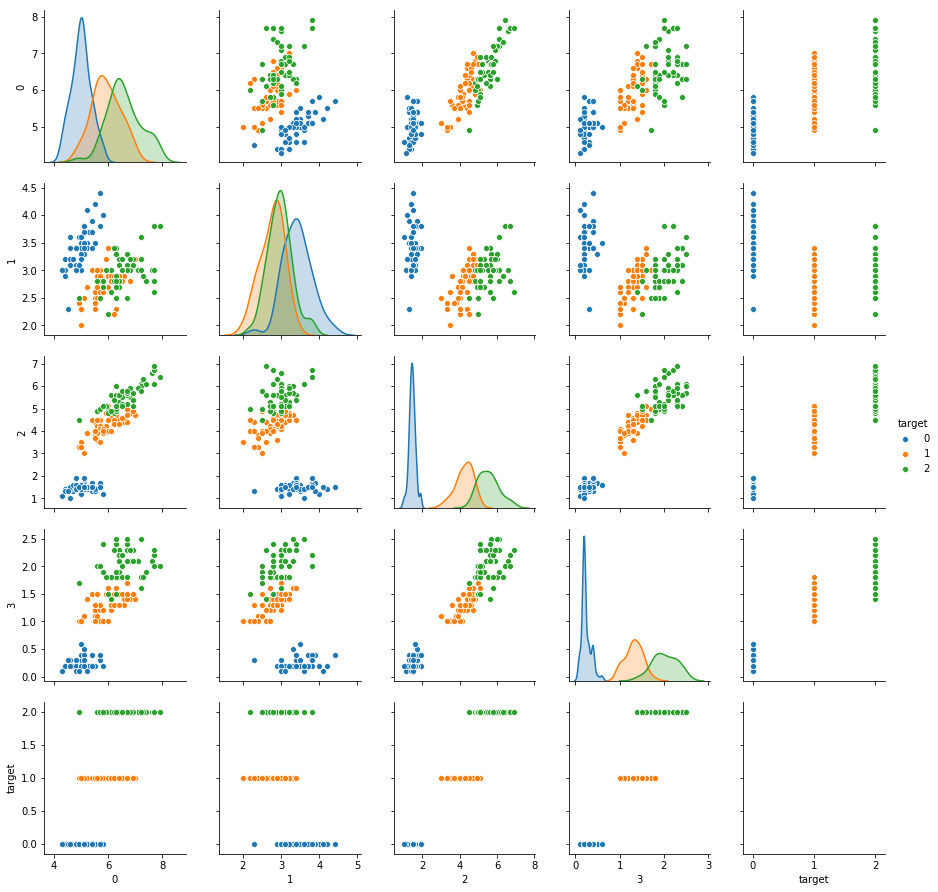

In [105]:
# Pairplot
sns.pairplot(data=iris_df, hue='target');

In [106]:
for column in iris_df.columns:
    if column == 'target':
        continue
    # feature standardization  
    iris_df[column] = iris_df[column].apply(lambda x: (x - iris_df[column].mean())/iris_df[column].std())

In [107]:
y = iris_df['target']
# one hot labels conversion
y_ = one_hot_labels(y.values)

X = iris_df.drop(columns='target', inplace=False)

# splitting into test/validation set
(X_train, X_test), (y_train, y_test) = train_test_split(X, y_, test_size=0.2)

## Model Evaluation
#### Hyperparamater tuning

In [116]:
# returns the prediction dictionary for each fold of cross validation
def for_each_fold(fold, folds, data, labels, model, model_args=None, error_function=None):
    # fold - train/val dataset
    (x_train, x_test), (y_train, y_test) = k_partition(data, labels, fold, folds)
    # one-hot labels
    y_train = one_hot_labels(y_train)
    y_test = one_hot_labels(y_test)
    
    # settting up model fitting paramters
    if model_args:
        if 'learning_rate' in model_args.keys():
            learning_rate=model_args['learning_rate']
        else:
            learning_rate=0.01
        if 'epochs' in model_args.keys():
            epochs=model_args['epochs']
        else:
            epochs=100
        if 'regularizer' in model_args.keys():
            regularizer=model_args['regularizer']
        else:
            regularizer='l2'
        if 'tol' in model_args.keys():
            tol=model_args['tol']
        else:
            tol=None
        if 'lambd' in model_args.keys():
            lambd=model_args['lambd']
        else:
            lambd=1.0
        if 'early_stopping' in model_args.keys():
            early_stopping=model_args['early_stopping']
        else:
            early_stopping=False
        if 'validation_fraction' in model_args.keys():
            validation_fraction = model_args['validation_fraction']
        else:
            validation_fraction=0.1
            
    # model fitting
    model.fit(x_train, y_train, learning_rate=learning_rate, epochs=epochs, tol=tol, regularizer=regularizer,
               early_stopping=early_stopping, validation_fraction=validation_fraction, lambd=lambd)
    y_pred = model.predict(x_test)

    # prediction and accuracy
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    if error_function == 'accuracy': 
        confusion_mat = confusion_matrix(y_pred, y_test.flatten())
        accuracy = np.sum(confusion_mat.diagonal())/np.sum(confusion_mat)
    return accuracy

# Cross-Validation function
def kFold(folds, data, labels, model, model_args=None, error_function=None):
    if error_function is None:
        error_function = 'accuracy'
        
    scores = list()    
    for fold in range(folds):
        score = for_each_fold(fold, folds, data, labels, model, model_args=model_args, error_function=error_function)
        scores.append(score)
        
    # returning n-fold scores array 
    return {"accuracy": scores, "mean": np.array(scores).mean()}

In [120]:
# lambd = [1.0, 0.1, 0.01, 0.001, 0.0001]
# tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
# learning_rate = [0.1, 0.01, 0.001]
# regularizer = ['l1', 'l2']


# After checking separately for subset of above parameters
# I reduce it to the following smaller range to test for time saving

lambd = [0.01,0.1, 1.0, 10]
tol = [0.0001, 0.00001, 0.000001]
learning_rate = [0.01, 0.05, 0.1]
regularizer = ['l1', 'l2']

In [121]:
# Hyperparameter greedy search

def customGridSearchCV():
    best_params = dict()
    accuracy0 = 0.0
    folds=5
    for l in lambd:
        for t in tol:
            for lr in learning_rate:
                for r in regularizer:
                    model = SoftmaxRegression()
                    model_args = {'learning_rate': lr, 'tol': t, 'regularizer': r, 'lambd': l}
                    out = kFold(folds, X.values, y.values, model=model, model_args=model_args)
                    mean_accuracy = out["mean"]
                    if mean_accuracy > accuracy0:
                        best_params = model_args
                        print(model_args)
                        print('accuracy: ', mean_accuracy)
                        accuracy0 = mean_accuracy
    return best_params, {'accuracy': accuracy0}

In [122]:
customGridSearchCV()

{'learning_rate': 0.01, 'tol': 0.0001, 'regularizer': 'l1', 'lambd': 0.01}
accuracy:  0.6666666666666666
{'learning_rate': 0.05, 'tol': 0.0001, 'regularizer': 'l1', 'lambd': 0.01}
accuracy:  0.74
{'learning_rate': 0.1, 'tol': 0.0001, 'regularizer': 'l1', 'lambd': 0.01}
accuracy:  0.7866666666666666


({'learning_rate': 0.1, 'tol': 0.0001, 'regularizer': 'l1', 'lambd': 0.01},
 {'accuracy': 0.7866666666666666})

#### prediction on test data

In [123]:
model = SoftmaxRegression()

model.fit(X_train, y_train, learning_rate=0.1, epochs=1000, tol=1e-4, regularizer='l1',
               early_stopping=False, lambd=0.01)

In [124]:
# prediction on test data
y_test_pred = model.predict(X_test)

In [125]:
confusion =confusion_matrix(np.argmax(y_test_pred, axis=1), np.argmax(y_test, axis=1))
print('confusion matrix: \n', confusion)

confusion matrix: 
 [[10.  0.  0.]
 [ 0.  6.  0.]
 [ 0.  6.  8.]]


In [127]:
print('Accuracy: ', np.sum(confusion.diagonal())/np.sum(confusion))

Accuracy:  0.8


####  Early stopping

Early stopping method is implemented in the SoftmaxRegression model above.

n_iter_no_change = stopped if no change in validation error for more than n_iter_no_change number of times.

In [141]:
model = SoftmaxRegression()
model.fit(X_train, y_train, learning_rate=0.01, epochs=1000, tol=1e-5, regularizer='l1',
               early_stopping=True, n_iter_no_change=250, validation_fraction=0.1, lambd=0.1)

early stopping enforced at epoch =  604


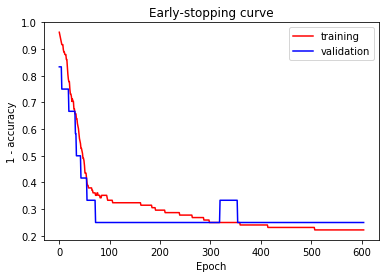

In [142]:
# early stopping curve plotting
model.early_stopping_curve()

#### Stochastic Softmax Regression

implements the stochastic gradient descent alogrithm for softmax logistic regression

In [154]:
class StochasticSoftmaxRegression:
    
    def __init__(self):
        self.error0 = None
        self.theta = None
        self.intercept_ = None
        self.coef_ = None
        # this list stores scores for early stopping
        self.training_scores = None
        self.validation_scores = None
        
    def softmax(self, score):
        softmax_score = np.empty(score.shape)
        for i in range(len(score)):
            softmax_score[i] = np.exp(score[i]) / sum(np.exp(score[i][j]) for j in range(len(score[i])))
        return softmax_score
    
    # returns cost with l2-regularization
    def l1_cost(self, W, X, y, lambd):
        y_pred = np.dot(X, W)
        cross_entropy = cross_entropy_loss(y_pred, y)
        penalty = (lambd/2) * np.sum(np.sum(W, axis=1), axis=0)
        return cross_entropy + penalty
    
    # returns cost with l2-regularization
    def l2_cost(self, W, X, y, lambd):
        y_pred = np.dot(X, W)
        cross_entropy = cross_entropy_loss(y_pred, y)
        Wjc_square = np.square(W)
        penalty = (lambd/2) * np.sum(np.sum(Wjc_square, axis=1), axis=0)
        return cross_entropy + penalty
    
    # decides wether to force break due to tolerance 
    def tolerance_break(self, epoch, error, tol):
        force_break = False
        if epoch == 0:
            self.error0 = error
        if tol and epoch > 0:
            if error > self.error0 - tol:
                force_break = True
        self.error0 = error
        #if force_break is True:
        #    print('Forcefully breaking at epoch = ', epoch)
        return force_break
    
    def mu(self, W, X):
        val = np.exp(np.dot(X, W))
        norm = np.sum(np.exp(np.dot(X, W)), axis=0)
        return np.divide(val, np.array(norm)) 
    
    
    def fit(self, X, y, learning_rate=0.01, epochs=100, tol=None, regularizer=None, 
            early_stopping=False, n_iter_no_change=50, validation_fraction=0.1, lambd=0.0, **kwargs):
        
        # adding a unit column in the input data: to find intercept
        X = np.c_[np.ones((X.shape[0], 1)), X]
        
        # if early stopping: separate validation dataset
        if early_stopping:
            (X, X_val), (y, y_val) = train_test_split(X, y, test_size=validation_fraction)
            self.training_scores = list()
            self.validation_scores = list()
        
        # number of samples and features
        n_samples, n_features = X.shape[0], X.shape[1]
        
        # initializing theta/weight
        np.random.seed(seed=100)
        
        #C = np.unique(y).shape[0]
        C = y.shape[1]
        theta_hat = np.random.rand(n_features, C)
        
        coeff = learning_rate/n_samples
        force_break = False
        stop = False
        for epoch in range(epochs):
            # random sample point: for each sample point in dataset at a time
            random_samples = np.random.randint(0, len(X), (len(X), ))
            for i in random_samples:
                X_i, y_i = np.array([X[i]]), np.array([y[i]])
                if not regularizer:
                    theta_hat = theta_hat - coeff * np.dot(X_i.T, self.mu(theta_hat, X_i) - y_i)
                    error = cross_entropy_loss(np.dot(X_i, theta_hat), y_i)

                if regularizer == 'l1':
                    theta_hat = theta_hat - coeff * (np.dot(X_i.T, self.mu(theta_hat, X_i) - y_i) + lambd * np.sign(theta_hat))
                    error = self.l1_cost(theta_hat, X_i, y_i, lambd)

                if regularizer == 'l2':
                    theta_hat = theta_hat - coeff * (np.dot(X_i.T, self.mu(theta_hat, X_i) - y_i) + lambd * theta_hat)
                    error = self.l2_cost(theta_hat, X_i, y_i, lambd)
                
            # Forced stopping: if tolerance is given
            if tol:
                if self.tolerance_break(epoch, error, tol) is True:
                    break 
            
            # Early Stopping
            if early_stopping:
                stop = self.early_stop(epoch, theta_hat, X, y, X_val, y_val, n_iter_no_change)
            if stop is True:
                print('early stopping enforced at epoch = ', epoch)
                break

        self.theta = theta_hat
        self.intercept_ = theta_hat[0]
        self.coef_ = theta_hat[1:]
        
    def early_stop(self, epoch, theta_hat, X_train, y_train, X_val, y_val, n_iter_no_change):
        # on training data
        y_train_pred = self.softmax(np.dot(X_train, theta_hat))
        y_train_pred = np.argmax(y_train_pred, axis=1)
        y_train = np.argmax(y_train, axis=1)
        confusion = confusion_matrix(y_train, y_train_pred)
        accuracy = np.sum(confusion.diagonal())/np.sum(confusion)
        # storing training accuracy
        self.training_scores.append(accuracy)
        
        # on validation data
        y_val_pred = self.softmax(np.dot(X_val, theta_hat))
        y_val_pred = np.argmax(y_val_pred, axis=1)
        y_val = np.argmax(y_val, axis=1)
        confusion = confusion_matrix(y_val, y_val_pred)
        accuracy = np.sum(confusion.diagonal())/np.sum(confusion)
        # storing validation accuracy
        self.validation_scores.append(accuracy)
        if len(self.validation_scores) < n_iter_no_change+1:
            return False
        
        # Breaking condition
        stop = False
        end = len(self.validation_scores)-1
        for i in range(end-n_iter_no_change, end):
            if self.validation_scores[i] == self.validation_scores[i+1]:
                stop = True
            else:
                stop = False
                break
        return stop
    
    # plots early stopping curve
    def early_stopping_curve(self):
        if self.validation_scores is None:
            raise ValueError('Early stopping training not done!')
        else:
            error_training = [1 - val for val in self.training_scores]
            error_validation = [1 - val for val in self.validation_scores]
            plt.plot(error_training, c='r', label='training')
            plt.plot(error_validation, c='b', label='validation')
            plt.legend()
            plt.title('Early-stopping curve')
            plt.xlabel('Epoch')
            plt.ylabel('1 - accuracy')
            plt.show()
            
    # prediction 
    def predict(self, X):
        '''also adding ones column into test data: gives intercept''' 
        X = np.c_[np.ones((X.shape[0], 1)), X]
        
        if self.theta is None:
            raise ValueError('The model is not fitted yet!')
            
        return self.softmax(np.dot(X, self.theta))

In [159]:
model2 = StochasticSoftmaxRegression()

model2.fit(X_train, y_train, learning_rate=0.01, epochs=1000, tol=None, regularizer='l1',
               early_stopping=False, lambd=0.1)

In [160]:
y_pred2 = np.argmax(model2.predict(X_test), axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred2)
print('confusion matrix: \n', conf_matrix)

confusion matrix: 
 [[10.  0.  0.]
 [ 0.  6.  6.]
 [ 0.  0.  8.]]


In [161]:
accuracy = np.sum(conf_matrix.diagonal())/np.sum(conf_matrix)
print('Accuracy: ', accuracy)

Accuracy:  0.8


In [162]:
# achieved similar accuracy with the Stochastic Softmax Regression to that of Softmax Regression

***Done!***